# Analysis of Daily Historical Meteorologic Variables from LOCA and BCSD, Annual Max

This notebook analyzes meteorologic variables from the historical scenario ...

Variables include:
- Precipitation
- Temperature
- Annual Max
- Wet day fraction

In [13]:
from loca import print_date
print_date()

Last executed: 2019-10-02 17:30:16.993550 by jvano on casper11


# Imports and Options

In [14]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import warnings
import glob
import cmocean

import matplotlib.pyplot as plt

import xarray as xr
import cmocean

from loca.data_catalog import load_monthly_historical_met_datasets, load_daily_livneh_meteorology, resample_monthly_data
from loca.utils import calc_change
from loca.plot import make_plot, PROJECTION, add_ylabel
from cmocean import cm

# list of 23:
models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1', 'bcc-csm1-1-m',
          'CESM1-BGC', 'CMCC-CM', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR',
          'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M', 'GFDL-ESM2G', 
          'CNRM-CM5', 'CSIRO-Mk3-6-0', 'GFDL-ESM2M','GFDL-CM3', 'HadGEM2-AO']


#cache is written in script "write_cache.ipynb"  TODO
read_cache = True
# cache_dir = os.environ['TMPDIR']
cache_dir = '/glade/u/home/jvano/scratch/'

# list to be plotted as individual gcms
models_ind_plot = ['ACCESS1-0', 'CanESM2', 'MIROC5'] 


hydro_met = 'hydro'  #or met hydro

if hydro_met == 'hydro':
    var3= 'total_runoff'
    met_vars = ['total_runoff']
    
if hydro_met == 'met':
    var3 = 'pcp'
    met_vars = ['pcp']  #TODO clean up var3 and met_vars so only one variable
    
read_cache = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.join(os.environ['HOME'], 'scheduler_file.json'))
client

Client Scheduler: tcp://128.117.181.217:37829 Dashboard: proxy/43560/status,Cluster Workers: 2 Cores: 4 Memory: 60.00 GB


# Load Data

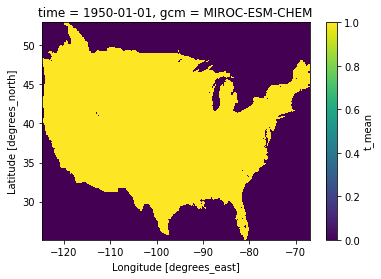

In [16]:
# just to get mask
openmask = xr.open_mfdataset(f'{cache_dir}/monthly_cmip_met_hist.bcsd_MIROC-ESM-CHEM.nc')
mask = openmask['t_mean'].isel(time=0).squeeze().notnull()
mask.plot()

In [34]:
# maurer_obs = xr.open_mfdataset('/glade/u/home/jvano/workdir/stats/annmax_hydro_bcsd_obs_maurer.nc')
# maurer_obs['pcp'].plot()

In [17]:
methods = ['bcsd', 'loca']
gard_methods = ['AR_uvq', 'AR_puv', 'PT_p']

def get_data(stat, gcms=models, methods=methods, gard_methods=gard_methods):
    ds_dict = {}

    for scen in ['hist', 'rcp45', 'rcp85']:
        concat_methods = []
        ds_list = []
        for method in methods:
#             fname = '/glade/u/home/jvano/workdir/stats/{stat}_{method}_{scen}_{gcm}.nc'
            fname = '/glade/u/home/jvano/workdir/stats/{stat}_{hydro_met}_{method}_{scen}_{gcm}.nc'
            files = [fname.format(stat=stat, hydro_met=hydro_met, method=method, scen=scen, gcm=gcm) for gcm in gcms]
            ds = xr.open_mfdataset(files, concat_dim=xr.Variable('gcm', gcms))
            # special handling for gard
            if 'config' in ds.dims:
                for gm in gard_methods:
                    if 'lat' in ds:
                        ds = ds.drop(['lat', 'lon']).rename({'y': 'lat', 'x': 'lon'})
                    concat_methods.append(gm)
                    ds_list.append(ds.sel(config=gm).drop('config'))
            else:
                concat_methods.append(method)
                ds_list.append(ds)
        ds_dict[scen] = xr.concat(ds_list, dim=xr.Variable('dsmethod', concat_methods)).where(mask)
    return ds_dict

In [18]:
ds_dict = {}
ds_dict = {"mean": get_data('mean'), "annmax": get_data('annmax'), "wetfrac": get_data('wetfrac')}

# Plots

For the daily variables, we will make plots:

1. Maps of all datasets plotted as actual values (epoch, seasonal, and monthly means)
2. Maps of all datasets with LOCA and BCSD datasets plotted as biases relative to observation based VIC simulations (epoch, seasonal, and monthly means)

In [19]:
var1 = 'annmax' # could be: mean, annmax, or wetfrac
dayconvert = {'mean': 365.25, 'annmax': 1, 'wetfrac': 1}
names = {'mean': 'Average', 'annmax': 'Annual Max', 'wetfrac': 'Wet Day Fraction'}

maurer = xr.open_mfdataset(f'/glade/u/home/jvano/workdir/stats/{var1}_{hydro_met}_bcsd_obs_maurer.nc').where(mask) * dayconvert[var1]
livneh = xr.open_mfdataset(f'/glade/u/home/jvano/workdir/stats/{var1}_{hydro_met}_loca_obs_livneh.nc').where(mask) * dayconvert[var1]
    
ens_means = {"bcsd": ds_dict[var1]['hist'].sel(dsmethod='bcsd').mean('gcm') * dayconvert[var1],
             "loca": ds_dict[var1]['hist'].sel(dsmethod='loca').mean('gcm') * dayconvert[var1]}
ens_stds = {"bcsd": ds_dict[var1]['hist'].sel(dsmethod='bcsd').std('gcm') * dayconvert[var1],
            "loca": ds_dict[var1]['hist'].sel(dsmethod='loca').std('gcm') * dayconvert[var1]}
indiv = {"bcsd": ds_dict[var1]['hist'].sel(dsmethod='bcsd') * dayconvert[var1],
         "loca": ds_dict[var1]['hist'].sel(dsmethod='loca') * dayconvert[var1]}

In [52]:
# Figure 18 and 22, OBS, ENSEMBLE MEAN, 3 GCMS for ANNUAL MAX PRECIP WORKS
# (FIG 18 ok, Fig 22 still has problems, trouble shooting in next box below)

if hydro_met == 'met':

    watercmap = cm.rain  #https://matplotlib.org/cmocean/
    watercmapdiff = 'BrBG'
    tempcmapdiff = 'RdBu_r'

    units = {'pcp': 'mm', 't_mean': 'C', 'total_runoff': 'mm'}
    variablename = {'t_mean': 'Temperature (C)', 'pcp': 'Precipitation (mm)', 'total_runoff': 'Runoff (mm)'}

    style_kwargs =  {'levels': 11, 'add_labels': False, 'cbar_kwargs': dict(orientation="horizontal", shrink=0.85, pad=0.03)}

    if var1 == 'mean':
        kwargs = {'pcp': {'vmin': 0, 'vmax': 2500},'t_mean': {'vmin': -10, 'vmax': 20}}
        diff_kws = {'pcp': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu'}, 't_mean': {'vmin': -1, 'vmax': 1, 'cmap': 'RdBu_r'}}
    #     std_kwargs = {'pcp': {'vmin': 0, 'vmax': 40}}
    #     diff_std_kws = {'pcp': {'vmin': -20, 'vmax': 20, 'cmap': 'RdBu'}}

    if var1 == 'annmax':
        kwargs = {'pcp': {'vmin': 0, 'vmax': 80, 'cmap':watercmap, **style_kwargs},
                  't_mean': {'vmin': -10, 'vmax': 20, **style_kwargs},
                  'total_runoff': {'vmin': 0, 'vmax': 40, 'cmap':watercmap, **style_kwargs}}  #FUNNY
        diff_kws = {'pcp': {'vmin': -20, 'vmax': 20, 'cmap': watercmapdiff, **style_kwargs}, 
                    't_mean': {'vmin': -1, 'vmax': 1, 'cmap': watercmapdiff,  **style_kwargs}, 
                    'total_runoff': {'vmin': -20, 'vmax': 20, 'cmap': watercmapdiff,  **style_kwargs}}
    #     std_kwargs = {'pcp': {'vmin': 0, 'vmax': 8}, 'total_runoff': {'vmin': 0, 'vmax': 8}}
    #     diff_std_kws = {'pcp': {'vmin': -2, 'vmax': 2, 'cmap': 'RdBu'}, 'total_runoff': {'vmin': -2, 'vmax': 2, 'cmap': 'RdBu'}}

    if var1 == 'wetfrac':
        kwargs = {'pcp': {'vmin': 0, 'vmax': 1, 'cmap': cmocean.cm.diff_r, **style_kwargs}, 
                  'total_runoff': {'vmin': 0, 'vmax': 1, 'cmap': cmocean.cm.diff_r, **style_kwargs}}
        diff_kws = {'pcp': {'vmin': -0.2, 'vmax': 0.2, 'cmap': 'RdBu', 'extend': 'both', **style_kwargs}, 
                    'total_runoff': {'vmin': -0.5, 'vmax': 0.5, 'cmap': 'RdBu', 'extend': 'both', **style_kwargs}}
    #     std_kwargs = {'pcp': {'vmin': 0, 'vmax': .01, 'cmap': cmocean.cm.diff_r, **style_kwargs},
    #                   'total_runoff': {'vmin': 0, 'vmax': .01, 'cmap': cmocean.cm.diff_r, **style_kwargs}}
    #     diff_std_kws = {'pcp': {'vmin': -.01, 'vmax': .01, 'cmap': 'RdBu', **style_kwargs}, 
    #                     'total_runoff': {'vmin': -.01, 'vmax': .01, 'cmap': 'RdBu', **style_kwargs}}


    nrows = 2 + len(models_ind_plot)
    ncols = 3

    for var in met_vars:

        fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 3.1*nrows), subplot_kw={'projection': PROJECTION})

        for col, (title, obs_data, ens_mean, ens_std, ds_data) in enumerate([('BCSD', maurer, ens_means['bcsd'], 
                                                                              ens_stds['bcsd'], indiv['bcsd']),
                                                                             ('LOCA', livneh, ens_means['loca'], 
                                                                              ens_stds['loca'], indiv['loca'])]):
            ax = axes[0, col]
            make_plot(obs_data[var], ax=ax, plot_kwargs=kwargs[var]) 
            ax.set_title(title, fontsize=16)

            if col == 0:
                add_ylabel(ax, 'OBS', fontsize=16)

            ax = axes[1, col]
            make_plot(ens_mean[var], ax=ax, plot_kwargs=kwargs[var]) 

            if col == 0:
                add_ylabel(ax, 'Ensemble Mean', fontsize=16)

            for row, model in enumerate(models_ind_plot, 2):
                ax = axes[row, col]
                make_plot(ds_data[var].sel(gcm=model), ax=ax, plot_kwargs=kwargs[var]) 

                if col == 0:
                    add_ylabel(ax, model, fontsize=16)

    # DIFF        
        ax = axes[0, -1]
        calc2 = calc_change(maurer[var], livneh[var])
        make_plot(calc2, ax=ax, plot_kwargs=diff_kws[var]) 
        ax.set_title('LOCA - BCSD', fontsize=16)  

        ax = axes[1, -1]
        calc = calc_change(ens_means['bcsd'][var], ens_means['loca'][var])
        make_plot(calc, ax=ax, plot_kwargs=diff_kws[var]) 

        diff = calc_change(indiv['bcsd'][var], indiv['loca'][var]).persist()

        for row, model in enumerate(models_ind_plot, 2):
            ax = axes[row, -1]  
            make_plot(diff.sel(gcm=model), ax=ax, plot_kwargs=diff_kws[var])
        title = variablename[var]
        title += ', %s' % names[var1]
        unit_str = units[var]
        fig.suptitle(title, fontsize=24, y=1.03)
        fig.tight_layout()     
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{var1}_{unit_str}_day_hist_{hydro_met}.png', dpi=300, bbox_inches='tight')

In [ ]:
# WITHOUT OBS

var1 = 'annmax' # could be: mean, annmax, or wetfrac
dayconvert = {'mean': 365.25, 'annmax': 1, 'wetfrac': 1}
names = {'mean': 'Average', 'annmax': 'Annual Max', 'wetfrac': 'Wet Day Fraction'}

# maurer = xr.open_mfdataset(f'/glade/u/home/jvano/workdir/stats/{var1}_{hydro_met}_bcsd_obs_maurer.nc').where(mask) * dayconvert[var1]
# livneh = xr.open_mfdataset(f'/glade/u/home/jvano/workdir/stats/{var1}_{hydro_met}_loca_obs_livneh.nc').where(mask) * dayconvert[var1]
    
ens_means = {"bcsd": ds_dict[var1]['hist'].sel(dsmethod='bcsd').mean('gcm') * dayconvert[var1],
             "loca": ds_dict[var1]['hist'].sel(dsmethod='loca').mean('gcm') * dayconvert[var1]}
ens_stds = {"bcsd": ds_dict[var1]['hist'].sel(dsmethod='bcsd').std('gcm') * dayconvert[var1],
            "loca": ds_dict[var1]['hist'].sel(dsmethod='loca').std('gcm') * dayconvert[var1]}
indiv = {"bcsd": ds_dict[var1]['hist'].sel(dsmethod='bcsd') * dayconvert[var1],
         "loca": ds_dict[var1]['hist'].sel(dsmethod='loca') * dayconvert[var1]}


if hydro_met == 'hydro':

    watercmap = cm.rain  #https://matplotlib.org/cmocean/
    watercmapdiff = 'BrBG'
    tempcmapdiff = 'RdBu_r'

    units = {'pcp': 'mm', 't_mean': 'C', 'total_runoff': 'mm'}
    variablename = {'t_mean': 'Temperature (C)', 'pcp': 'Precipitation (mm)', 'total_runoff': 'Runoff (mm)'}

    style_kwargs =  {'levels': 11, 'add_labels': False, 'cbar_kwargs': dict(orientation="horizontal", shrink=0.85, pad=0.03)}

    if var1 == 'mean':
        kwargs = {'pcp': {'vmin': 0, 'vmax': 2500},'t_mean': {'vmin': -10, 'vmax': 20}}
        diff_kws = {'pcp': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu'}, 't_mean': {'vmin': -1, 'vmax': 1, 'cmap': 'RdBu_r'}}
    #     std_kwargs = {'pcp': {'vmin': 0, 'vmax': 40}}
    #     diff_std_kws = {'pcp': {'vmin': -20, 'vmax': 20, 'cmap': 'RdBu'}}

    if var1 == 'annmax':
        kwargs = {'pcp': {'vmin': 0, 'vmax': 80, 'cmap':watercmap, **style_kwargs},
                  't_mean': {'vmin': -10, 'vmax': 20, **style_kwargs},
                  'total_runoff': {'vmin': 0, 'vmax': 40, 'cmap':watercmap, **style_kwargs}}  #FUNNY
        diff_kws = {'pcp': {'vmin': -20, 'vmax': 20, 'cmap': watercmapdiff, **style_kwargs}, 
                    't_mean': {'vmin': -1, 'vmax': 1, 'cmap': watercmapdiff,  **style_kwargs}, 
                    'total_runoff': {'vmin': -20, 'vmax': 20, 'cmap': watercmapdiff,  **style_kwargs}}
    #     std_kwargs = {'pcp': {'vmin': 0, 'vmax': 8}, 'total_runoff': {'vmin': 0, 'vmax': 8}}
    #     diff_std_kws = {'pcp': {'vmin': -2, 'vmax': 2, 'cmap': 'RdBu'}, 'total_runoff': {'vmin': -2, 'vmax': 2, 'cmap': 'RdBu'}}

    if var1 == 'wetfrac':
        kwargs = {'pcp': {'vmin': 0, 'vmax': 1, 'cmap': cmocean.cm.diff_r, **style_kwargs}, 
                  'total_runoff': {'vmin': 0, 'vmax': 1, 'cmap': cmocean.cm.diff_r, **style_kwargs}}
        diff_kws = {'pcp': {'vmin': -0.2, 'vmax': 0.2, 'cmap': 'RdBu', 'extend': 'both', **style_kwargs}, 
                    'total_runoff': {'vmin': -0.5, 'vmax': 0.5, 'cmap': 'RdBu', 'extend': 'both', **style_kwargs}}
    #     std_kwargs = {'pcp': {'vmin': 0, 'vmax': .01, 'cmap': cmocean.cm.diff_r, **style_kwargs},
    #                   'total_runoff': {'vmin': 0, 'vmax': .01, 'cmap': cmocean.cm.diff_r, **style_kwargs}}
    #     diff_std_kws = {'pcp': {'vmin': -.01, 'vmax': .01, 'cmap': 'RdBu', **style_kwargs}, 
    #                     'total_runoff': {'vmin': -.01, 'vmax': .01, 'cmap': 'RdBu', **style_kwargs}}


    nrows = 2 + len(models_ind_plot)
    ncols = 3

    for var in met_vars:

        fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 3.1*nrows), subplot_kw={'projection': PROJECTION})

        for col, (title, obs_data, ens_mean, ens_std, ds_data) in enumerate([('BCSD', maurer, ens_means['bcsd'], 
                                                                              ens_stds['bcsd'], indiv['bcsd']),
                                                                             ('LOCA', livneh, ens_means['loca'], 
                                                                              ens_stds['loca'], indiv['loca'])]):
            ax = axes[0, col]
            make_plot(obs_data[var], ax=ax, plot_kwargs=kwargs[var]) 
            ax.set_title(title, fontsize=16)

            if col == 0:
                add_ylabel(ax, 'OBS', fontsize=16)

            ax = axes[1, col]
            make_plot(ens_mean[var], ax=ax, plot_kwargs=kwargs[var]) 

            if col == 0:
                add_ylabel(ax, 'Ensemble Mean', fontsize=16)

            for row, model in enumerate(models_ind_plot, 2):
                ax = axes[row, col]
                make_plot(ds_data[var].sel(gcm=model), ax=ax, plot_kwargs=kwargs[var]) 

                if col == 0:
                    add_ylabel(ax, model, fontsize=16)

    # DIFF        
        ax = axes[0, -1]
        calc2 = calc_change(maurer[var], livneh[var]) #commented out for now (until read in obs)
        make_plot(calc2, ax=ax, plot_kwargs=diff_kws[var]) 
        ax.set_title('LOCA - BCSD', fontsize=16)  

        ax = axes[1, -1]
        calc = calc_change(ens_means['bcsd'][var], ens_means['loca'][var])
        make_plot(calc, ax=ax, plot_kwargs=diff_kws[var]) 

        diff = calc_change(indiv['bcsd'][var], indiv['loca'][var]).persist()

        for row, model in enumerate(models_ind_plot, 2):
            ax = axes[row, -1]  
            make_plot(diff.sel(gcm=model), ax=ax, plot_kwargs=diff_kws[var])

        title = variablename[var]
        title += ', %s' % names[var1]
        unit_str = units[var]
        fig.suptitle(title, fontsize=24, y=1.03)
        fig.tight_layout()     
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{var1}_{unit_str}_day_hist_{hydro_met}.png', dpi=300, bbox_inches='tight')

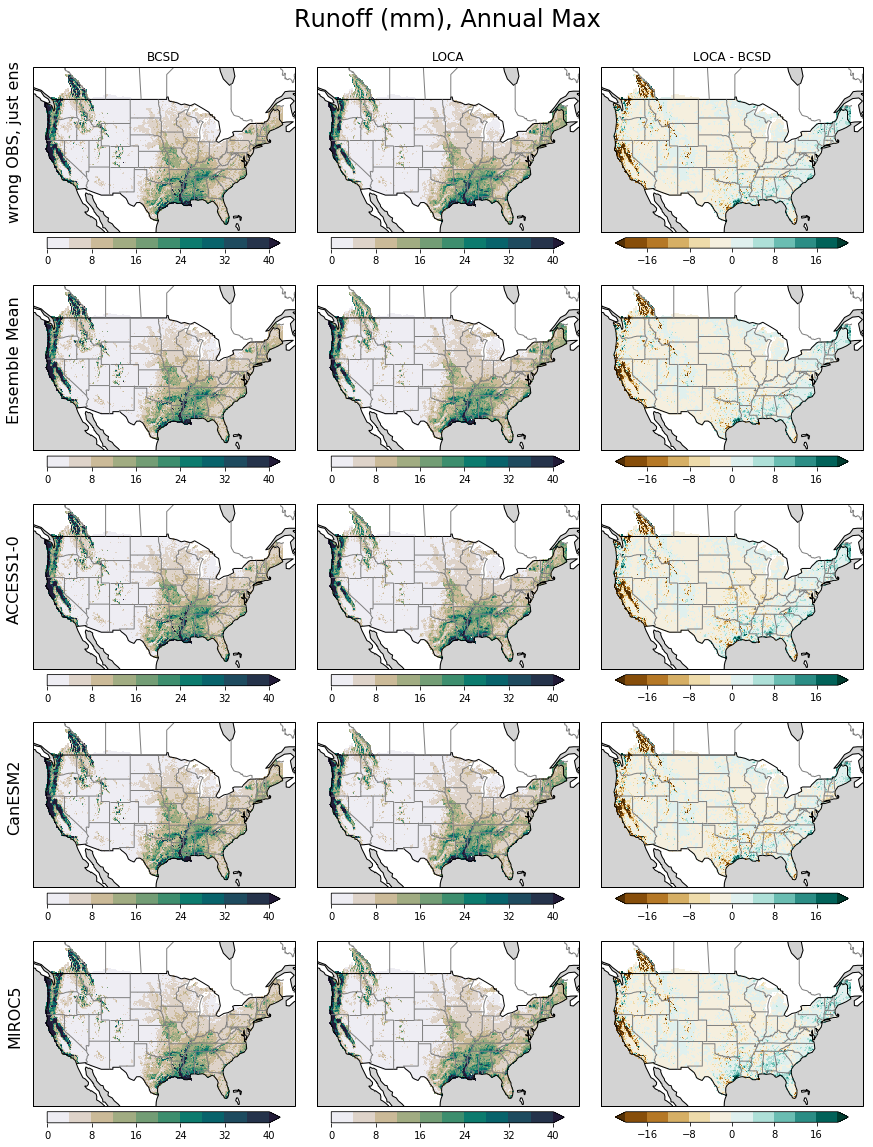

In [14]:
# WORKING ON (similar to above, but getting it to plot hydro without obs)


#just dummy variables to get it to plot.
maurer = xr.open_mfdataset(f'/glade/u/home/jvano/workdir/stats/annmax_met_bcsd_obs_maurer.nc').where(mask) * dayconvert[var1]
livneh = xr.open_mfdataset(f'/glade/u/home/jvano/workdir/stats/annmax_met_loca_obs_livneh.nc').where(mask) * dayconvert[var1]

#what really need to work:
# maurer = xr.open_mfdataset(f'/glade/u/home/jvano/workdir/stats/{var1}_{hydro_met}_bcsd_obs_maurer.nc').where(mask) * dayconvert[var1]
# livneh = xr.open_mfdataset(f'/glade/u/home/jvano/workdir/stats/{var1}_{hydro_met}_loca_obs_livneh.nc').where(mask) * dayconvert[var1]

watercmap = cm.rain  #https://matplotlib.org/cmocean/
watercmapdiff = 'BrBG'
tempcmapdiff = 'RdBu_r'

units = {'pcp': 'mm', 't_mean': 'C', 'total_runoff': 'mm'}
# variablename = {'t_mean': 'Temperature (C)', 'pcp': 'Precipitation (mm)', 'total_runoff': 'Runoff (mm)'}

style_kwargs =  {'levels': 11, 'add_labels': False, 'cbar_kwargs': dict(orientation="horizontal", shrink=0.85, pad=0.03)}

if var1 == 'mean':
    kwargs = {'pcp': {'vmin': 0, 'vmax': 2500},'t_mean': {'vmin': -10, 'vmax': 20}}
    std_kwargs = {'pcp': {'vmin': 0, 'vmax': 40}}
    diff_kws = {'pcp': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu'}, 't_mean': {'vmin': -1, 'vmax': 1, 'cmap': 'RdBu_r'}}
    diff_std_kws = {'pcp': {'vmin': -20, 'vmax': 20, 'cmap': 'RdBu'}}

if var1 == 'annmax':
    kwargs = {'pcp': {'vmin': 0, 'vmax': 80, 'cmap':watercmap, **style_kwargs},
              't_mean': {'vmin': -10, 'vmax': 20, **style_kwargs},
              'total_runoff': {'vmin': 0, 'vmax': 40, 'cmap':watercmap, **style_kwargs}}
#     std_kwargs = {'pcp': {'vmin': 0, 'vmax': 8}, 'total_runoff': {'vmin': 0, 'vmax': 8}}
    diff_kws = {'pcp': {'vmin': -20, 'vmax': 20, 'cmap': watercmapdiff, **style_kwargs}, 
                't_mean': {'vmin': -1, 'vmax': 1, 'cmap': watercmapdiff,  **style_kwargs}, 
                'total_runoff': {'vmin': -20, 'vmax': 20, 'cmap': watercmapdiff,  **style_kwargs}}
#     diff_std_kws = {'pcp': {'vmin': -2, 'vmax': 2, 'cmap': 'RdBu'}, 'total_runoff': {'vmin': -2, 'vmax': 2, 'cmap': 'RdBu'}}

if var1 == 'wetfrac':
    kwargs = {'pcp': {'vmin': 0, 'vmax': 1, 'cmap': cmocean.cm.diff_r, **style_kwargs}, 
              'total_runoff': {'vmin': 0, 'vmax': 1, 'cmap': cmocean.cm.diff_r, **style_kwargs}}
    std_kwargs = {'pcp': {'vmin': 0, 'vmax': .01, 'cmap': cmocean.cm.diff_r, **style_kwargs},
                  'total_runoff': {'vmin': 0, 'vmax': .01, 'cmap': cmocean.cm.diff_r, **style_kwargs}}
    diff_kws = {'pcp': {'vmin': -0.2, 'vmax': 0.2, 'cmap': 'RdBu', 'extend': 'both', **style_kwargs}, 
                'total_runoff': {'vmin': -0.5, 'vmax': 0.5, 'cmap': 'RdBu', 'extend': 'both', **style_kwargs}}
    diff_std_kws = {'pcp': {'vmin': -.01, 'vmax': .01, 'cmap': 'RdBu', **style_kwargs}, 
                    'total_runoff': {'vmin': -.01, 'vmax': .01, 'cmap': 'RdBu', **style_kwargs}}

    
nrows = 2 + len(models_ind_plot)
ncols = 3


for var in met_vars:
    
#     fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 2*nrows))
#     fig, axes = plt.subplots(ncols=ncols + 1, nrows=nrows, sharex=True, sharey=True, figsize=(12, 3.1*nrows), subplot_kw={'projection': PROJECTION})
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 3.1*nrows), subplot_kw={'projection': PROJECTION})
                
    for col, (title, obs_data, ens_mean, ens_std, ds_data) in enumerate([('BCSD', maurer, ens_means['bcsd'], 
                                                                          ens_stds['bcsd'], indiv['bcsd']),
                                                                         ('LOCA', livneh, ens_means['loca'], 
                                                                          ens_stds['loca'], indiv['loca'])]):
        ax = axes[0, col]
#         obs_data[var].plot.pcolormesh(ax=ax,  **kwargs[var])
#         make_plot(obs_data[var], ax=ax, plot_kwargs=kwargs[var]) #commented out if can't read obs (for hydrology)
        make_plot(ens_mean[var], ax=ax, plot_kwargs=kwargs[var])# just added to get it to plot
        ax.set_title(title)
        
        if col == 0:
#             ax.set_ylabel('OBS')
            add_ylabel(ax, 'wrong OBS, just ens', fontsize=16)
        
        ax = axes[1, col]
#         ens_mean[var].plot.pcolormesh(ax=ax,  **kwargs[var])
        make_plot(ens_mean[var], ax=ax, plot_kwargs=kwargs[var]) 
        
        if col == 0:
            add_ylabel(ax, 'Ensemble Mean', fontsize=16)
            
#         ax = axes[2, col]
#         ens_std[var].plot.pcolormesh(ax=ax,  **std_kwargs[var])
#         if col == 0:
#             ax.set_ylabel('Ensemble Std')
        
        for row, model in enumerate(models_ind_plot, 2):
            ax = axes[row, col]
#             ds_data[var].sel(gcm=model).plot.pcolormesh(ax=ax, **kwargs[var])
            make_plot(ds_data[var].sel(gcm=model), ax=ax, plot_kwargs=kwargs[var]) 
            
            if col == 0:
#                 ax.set_ylabel(model)
                add_ylabel(ax, model, fontsize=16)
                
# DIFF        
    ax = axes[0, -1]
#     calc2 = calc_change(maurer[var], livneh[var]) #commented out for now (until read in obs)
#     make_plot(calc2, ax=ax, plot_kwargs=diff_kws[var]) 
    calc = calc_change(ens_means['bcsd'][var], ens_means['loca'][var]) # just added so it would plot
    make_plot(calc, ax=ax, plot_kwargs=diff_kws[var]) # just added so it would plot
    ax.set_title('LOCA - BCSD')  
        
    ax = axes[1, -1]
    calc = calc_change(ens_means['bcsd'][var], ens_means['loca'][var])
    make_plot(calc, ax=ax, plot_kwargs=diff_kws[var]) 

#     ax = axes[2, -1]
#     calc_change(ens_stds['bcsd'][var], ens_stds['loca'][var]).plot.pcolormesh(ax=ax, **diff_std_kws[var])

    diff = calc_change(indiv['bcsd'][var], indiv['loca'][var]).persist()
    
    for row, model in enumerate(models_ind_plot, 2):
        ax = axes[row, -1]  
#         diff.sel(gcm=model).plot.pcolormesh(ax=ax, **diff_kws[var])
        make_plot(diff.sel(gcm=model), ax=ax, plot_kwargs=diff_kws[var])

#     title = var.upper()
#     title += ' (%s),' % units[var]
    variablename = {'t_mean': 'Temperature (C)', 'pcp': 'Precipitation (mm)', 'total_runoff': 'Runoff (mm)'}
    title = variablename[var]
    title += ', %s' % names[var1]
    unit_str = units[var]
    fig.suptitle(title, fontsize=24, y=1.03)
    fig.tight_layout()     
    fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{var1}_{unit_str}_day_hist_{hydro_met}.png', dpi=300, bbox_inches='tight')

In [20]:
# PLOTTING CHANGE SIGNALS

rcp = 'rcp85'  #rpc45 or rcp85

ds_dict2 = get_data(var1)
pct = 'True'
da = calc_change(ds_dict2['hist'][var3], ds_dict2[rcp][var3], pct='False')     

<xarray.DataArray 'total_runoff' (lat: 222, lon: 462)>
dask.array<shape=(222, 462), dtype=float32, chunksize=(222, 462)>
Coordinates:
  * lat       (lat) float64 25.19 25.31 25.44 25.56 ... 52.44 52.56 52.69 52.81
  * lon       (lon) float64 -124.7 -124.6 -124.4 -124.3 ... -67.31 -67.19 -67.06
    gcm       <U14 'ACCESS1-0'
    dsmethod  <U4 'loca'
    time      datetime64[ns] 1950-01-01

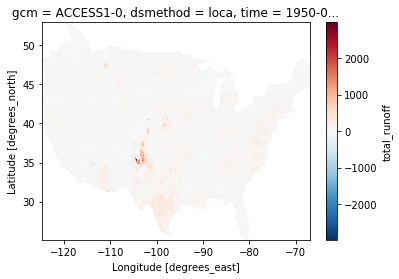

In [21]:
da_ens_means = {"bcsd": da.sel(dsmethod='bcsd').mean('gcm'),
               "loca": da.sel(dsmethod='loca').mean('gcm')}
da_ens_stds = {"bcsd": da.sel(dsmethod='bcsd').std('gcm'),
               "loca": da.sel(dsmethod='loca').std('gcm')}
da_indiv = {"bcsd": da.sel(dsmethod='bcsd'), "loca": da.sel(dsmethod='loca')}
display (da_indiv['loca'].sel(gcm='ACCESS1-0'))
da_indiv['loca'].sel(gcm='ACCESS1-0').plot()

In [46]:
# ds_dict2 = get_data(var1)
# pct = 'True'
# da = calc_change(ds_dict2['hist'][var3], ds_dict2[rcp][var3], pct='True')  

# da_ens_means = {"bcsd": da.sel(dsmethod='bcsd').mean('gcm'),
#                "loca": da.sel(dsmethod='loca').mean('gcm')}
# da_ens_stds = {"bcsd": da.sel(dsmethod='bcsd').std('gcm'),
#                "loca": da.sel(dsmethod='loca').std('gcm')}
# da_indiv = {"bcsd": da.sel(dsmethod='bcsd'), "loca": da.sel(dsmethod='loca')}
# display (da_indiv['loca'].sel(gcm='ACCESS1-0'))
# da_indiv['loca'].sel(gcm='ACCESS1-0').plot()

#TODO question  - why doesn't this come out different as it's a percent vs. not a percent

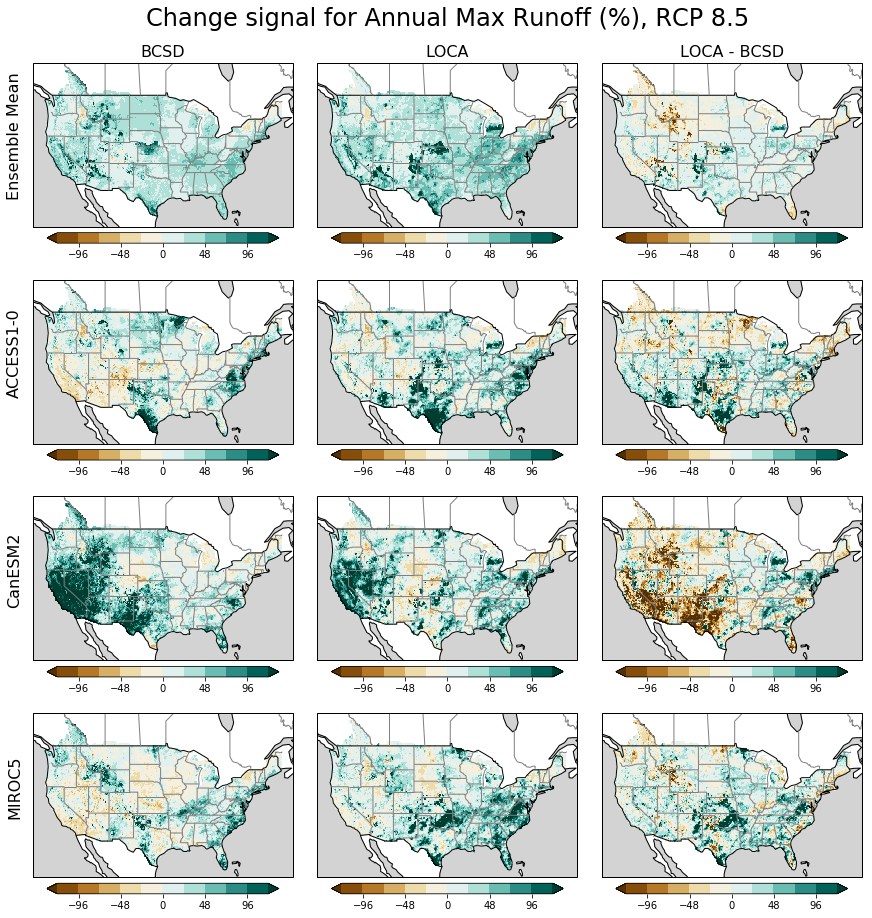

In [22]:
#FIGURES with DIFF

watercmap = cm.rain  #https://matplotlib.org/cmocean/
watercmapdiff = 'BrBG'
tempcmapdiff = 'RdBu_r'

models_ind_plot = ['ACCESS1-0', 'CanESM2', 'MIROC5']

nrows = 1 + len(models_ind_plot)
ncols = 3

units = {'pcp': 'mm', 't_mean': 'C'}

style_kwargs =  {'levels': 11, 'add_labels': False, 'extend': 'both', 'cbar_kwargs': dict(orientation="horizontal", shrink=0.85, pad=0.03)}

if var1 == 'annmax':
    kwargs = {'pcp': {'vmin': -50, 'vmax': 50, 'cmap': watercmap,  **style_kwargs},
              't_mean': {'vmin': -10, 'vmax': 20, 'extend': 'both', **style_kwargs},
              'total_runoff': {'vmin': 0, 'vmax': 120, 'cmap': watercmap, **style_kwargs}}
    diff_kws = {'pcp': {'vmin': -40, 'vmax': 40, 'cmap': watercmapdiff, 'extend': 'both', **style_kwargs}, 
                't_mean': {'vmin': -1, 'vmax': 1, 'cmap': tempcmapdiff, 'extend': 'both', **style_kwargs}, 
                'total_runoff': {'vmin': -120, 'vmax': 120, 'cmap': watercmapdiff, 'extend': 'both', **style_kwargs}}
#     std_kwargs = {'pcp': {'vmin': -20, 'vmax': 20, 'cmap': 'RdBu', **style_kwargs}, 
#                   'total_runoff': {'vmin': -60, 'vmax': 60, 'cmap': 'RdBu', **style_kwargs}}
#     diff_std_kws = {'pcp': {'vmin': -20, 'vmax': 20, 'cmap': 'RdBu', **style_kwargs},
#                     'total_runoff': {'vmin': -60, 'vmax': 60, 'cmap': 'RdBu', **style_kwargs}}
                
if var1 == 'mean':
    kwargs = {'pcp': {'vmin': -40, 'vmax': 40, 'cmap': cmocean.cm.diff_r},'t_mean': {'vmin': -10, 'vmax': 20}}
    diff_kws = {'pcp': {'vmin': -40, 'vmax': 40, 'cmap': 'RdBu'}, 't_mean': {'vmin': -1, 'vmax': 1, 'cmap': 'RdBu_r'}}
#     std_kwargs = {'pcp': {'vmin': -20, 'vmax': 20, 'cmap': cmocean.cm.diff_r}}
#     diff_std_kws = {'pcp': {'vmin': -20, 'vmax': 20, 'cmap': 'RdBu'}}
    
if var1 == 'wetfrac':
    kwargs = {'pcp': {'vmin': -15, 'vmax': 15, 'cmap': cmocean.cm.diff_r, **style_kwargs}}
    diff_kws = {'pcp': {'vmin': -15, 'vmax': 15, 'cmap': 'RdBu', **style_kwargs}}
#     std_kwargs = {'pcp': {'vmin': -20, 'vmax': 20, 'cmap': cmocean.cm.diff_r, **style_kwargs}}
#     diff_std_kws = {'pcp': {'vmin': -20, 'vmax': 20, 'cmap': 'RdBu', **style_kwargs}}
    



for var in met_vars:
    
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 3.1*nrows), subplot_kw={'projection': PROJECTION})
       
    for col, (title, ens_mean, ens_std, ds_data) in enumerate([('BCSD', da_ens_means['bcsd'], da_ens_stds['bcsd'], da_indiv['bcsd']),
                                                                         ('LOCA', da_ens_means['loca'], da_ens_stds['loca'], da_indiv['loca'])]):
        ax = axes[0, col]
#         ens_mean.plot.pcolormesh(ax=ax, **kwargs[var3])
#         make_plot(ens_mean, ax=ax, plot_kwargs=kwargs[var]) #from above
        make_plot(ens_mean, ax=ax, plot_kwargs=diff_kws[var])
        
        ax.set_title(title, fontsize=16)
        
        if col == 0:
            add_ylabel(ax, 'Ensemble Mean', fontsize=16)

#         ax = axes[1, col]
#         ens_std.plot.pcolormesh(ax=ax,  **std_kwargs[var3])
        
#         if col == 0:
#             ax.set_ylabel('Ensemble Std')
        
        for row, model in enumerate(models_ind_plot, 1):
            ax = axes[row, col]
#             ens_change = calc_change(hist_met_means[dset][var].mean('gcm'), rcpfilename[rcp][dset][var].mean('gcm'), pct=pct)
#             ds_data.sel(gcm=model).plot.pcolormesh(ax=ax,  **kwargs[var3])
            make_plot(ds_data.sel(gcm=model), ax=ax, plot_kwargs=diff_kws[var]) 
            
            if col == 0:
#                 ax.set_ylabel(model)
                add_ylabel(ax, model, fontsize=16)
                
# DIFF        
    ax = axes[0, -1]
#     calc_change(da_ens_means['bcsd'], da_ens_means['loca']).plot.pcolormesh(ax=ax, **diff_kws[var3])
    ax.set_title('LOCA - BCSD', fontsize=16)  
    calc = calc_change(da_ens_means['bcsd'], da_ens_means['loca'])
    make_plot(calc, ax=ax, plot_kwargs=diff_kws[var])
#     ax = axes[1, -1]
#     calc_change(da_ens_stds['bcsd'], da_ens_stds['loca']).plot.pcolormesh(ax=ax, **diff_std_kws[var3])

    ax = axes[1, -1]
#     calc_change(ens_stds['bcsd'][var], ens_stds['loca'][var]).plot.pcolormesh(ax=ax, **diff_std_kws[var])
    diff = calc_change(da_indiv['bcsd'], da_indiv['loca'], pct=False).persist()
    
    for row, model in enumerate(models_ind_plot, 2):
        ax = axes[row - 1, -1]   #TODO not sure why row is one too big
#         diff.sel(gcm=model).plot.pcolormesh(ax=ax, **diff_kws[var3])
        make_plot(diff.sel(gcm=model), ax=ax, plot_kwargs=diff_kws[var])
        
    longnamevar = {'t_mean': 'Temperature', 'pcp': 'Precipitation', 'total_runoff': 'Runoff'}
    longnamercp = {'rcp85': 'RCP 8.5', 'rcp45': 'RCP 4.5'}
    title = 'Change signal for '
    title += names[var1]
    title += ' '
    title += longnamevar[var]
    title += ' (%), ' 
    title += longnamercp[rcp]
    unit_str = 'pct'
fig.suptitle(title, fontsize=24, y=1.03)
fig.tight_layout()     
fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{var1}_{unit_str}_day_fut_{rcp}_{hydro_met}.png', dpi=300, bbox_inches='tight')

In [31]:
display (pct)

'True'

In [ ]:
# cleanup 
plt.close('all')